<a id='top'></a>

# 3) Expected Goals Modeling using Wyscout Event Data - Random Forest Modelling
##### Notebook to create an Expected Goals (xG) model using a full season of publicly available [Wyscout](https://wyscout.com/) Event data

### By [Edd Webster](https://www.twitter.com/eddwebster)
Notebook first written: 26/01/2021<br>
Notebook last updated: 31/01/2021

![title](../../../img/expected_goals_visual.png)

Photo credit to David Sumpter ([@Soccermatics](https://twitter.com/Soccermatics?))

---

## <a id='import_libraries'>Introduction</a>
This notebook is a short walk-through of how to create an Expected Goals (xG) model using a season's worth of [Wyscout](https://wyscout.com/) Event data for the 'Big 5' European leagues, in [Python](https://www.python.org/), using [pandas](http://pandas.pydata.org/) DataFrames, [XGBoost](https://xgboost.readthedocs.io/en/latest/) and [scikit-learn](https://scikit-learn.org/stable/) for Machine Learning, and [matplotlib](https://matplotlib.org/contents.html?v=20200411155018) visualisations.

For more information about this notebook and the author, I'm available through all the following channels:
*    [eddwebster.com](https://www.eddwebster.com/);
*    edd.j.webster@gmail.com;
*    [@eddwebster](https://www.twitter.com/eddwebster);
*    [linkedin.com/in/eddwebster](https://www.linkedin.com/in/eddwebster/);
*    [github/eddwebster](https://github.com/eddwebster/);
*    [public.tableau.com/profile/edd.webster](https://public.tableau.com/profile/edd.webster);
*    [kaggle.com/eddwebster](https://www.kaggle.com/eddwebster); and
*    [hackerrank.com/eddwebster](https://www.hackerrank.com/eddwebster).

![title](../../../img/fifa21eddwebsterbanner.png)

The accompanying GitHub repository for this notebook can be found [here](https://github.com/eddwebster/football_analytics) and a static version of this notebook can be found [here](https://nbviewer.jupyter.org/github/eddwebster/football_analytics/blob/master/notebooks/A%29%20Web%20Scraping/TransferMarkt%20Web%20Scraping%20and%20Parsing.ipynb).

___

<a id='sectioncontents'></a>

## <a id='notebook_contents'>Notebook Contents</a>
1.    [Notebook Dependencies](#section1)<br>
2.    [Project Brief](#section2)<br>
3.    [Data Sources](#section3)<br>
      1.    [Introduction](#section3.1)<br>
      2.    [Data Dictionary](#section3.2)<br>
      3.    [Creating the DataFrame](#section3.3)<br>
      4.    [Initial Data Handling](#section3.4)<br>
      5.    [Export the Raw DataFrame](#section3.5)<br>         
4.    [Data Engineering](#section4)<br>
5.    [Feature Engineering](#section5)<br>
6.    [Machine Learning Modelling](#section6)<br>
7.    [Model Evaluation](#section7)<br>
8.    [Summary](#section8)<br>
9.    [Next Steps](#section9)<br>
10.    [Bibliography](#section10)<br>

---

## <a id='#section1'>1. Notebook Dependencies</a>

This notebook was written using [Python 3](https://docs.python.org/3.7/) and requires the following libraries:
*    [`Jupyter notebooks`](https://jupyter.org/) for this notebook environment with which this project is presented;
*    [`NumPy`](http://www.numpy.org/) for multidimensional array computing;
*    [`pandas`](http://pandas.pydata.org/) for data analysis and manipulation;
*    [`Beautifulsoup`](https://pypi.org/project/beautifulsoup4/) for web scraping; and
*    [`matplotlib`](https://matplotlib.org/contents.html?v=20200411155018) for data visualisations;

All packages used for this notebook except for BeautifulSoup can be obtained by downloading and installing the [Conda](https://anaconda.org/anaconda/conda) distribution, available on all platforms (Windows, Linux and Mac OSX). Step-by-step guides on how to install Anaconda can be found for Windows [here](https://medium.com/@GalarnykMichael/install-python-on-windows-anaconda-c63c7c3d1444) and Mac [here](https://medium.com/@GalarnykMichael/install-python-on-mac-anaconda-ccd9f2014072), as well as in the Anaconda documentation itself [here](https://docs.anaconda.com/anaconda/install/).

### Import Libraries and Modules

In [46]:
%load_ext autoreload
%autoreload 2

# Python ≥3.5 (ideally)
import platform
import sys, getopt
assert sys.version_info >= (3, 5)
import csv

# Import Dependencies
%matplotlib inline

# Math Operations
import numpy as np
import math
from math import pi

# Datetime
import datetime
from datetime import date
import time

# Data Preprocessing
import pandas as pd
import os
import re
import random
from io import BytesIO
from pathlib import Path

# Reading directories
import glob
import os
from os.path import basename

# Working with JSON
import json
from pandas.io.json import json_normalize

# Data Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.patches import Arc
import seaborn as sns
#plt.style.use('seaborn-whitegrid')
import missingno as msno

# Downloading data sources
from urllib.parse import urlparse
from urllib.request import urlopen, urlretrieve
from zipfile import ZipFile, is_zipfile
from tqdm import tqdm    # Progress Bar

# Football libraries
import FCPython
#from FCPython import createPitch
import matplotsoccer
import socceraction.classification.features as features
import socceraction.classification.labels as labels
from socceraction.spadl.wyscout import convert_to_spadl
from socceraction.vaep import value

# Machine Learning
import scipy as sp
from scipy.spatial import distance
from sklearn.ensemble import RandomForestClassifier
#from sklearn.inspection import permutation_importance
from sklearn.metrics import log_loss, brier_score_loss, roc_auc_score , roc_curve, average_precision_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from scikitplot.metrics import plot_roc_curve, plot_precision_recall_curve, plot_calibration_curve
from xgboost import XGBClassifier   # version 1.0.2
import catboost    # pip install catboost if you don't have it
from catboost import CatBoostClassifier, Pool, cv

# Display in Jupyter
from IPython.display import Image, Video, YouTubeVideo
from IPython.core.display import HTML

# Ignore Warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

print('Setup Complete')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Setup Complete


In [4]:
# Python / module versions used here for reference
print('Python: {}'.format(platform.python_version()))
print('NumPy: {}'.format(np.__version__))
print('pandas: {}'.format(pd.__version__))
print('matplotlib: {}'.format(mpl.__version__))
print('Seaborn: {}'.format(sns.__version__))

Python: 3.7.6
NumPy: 1.18.0
pandas: 1.2.0
matplotlib: 3.3.2
Seaborn: 0.11.1


### Defined Variables

In [5]:
# Define today's date
today = datetime.datetime.now().strftime('%d/%m/%Y').replace('/', '')

### Defined Filepaths

In [6]:
# Set up initial paths to subfolders
base_dir = os.path.join('..', '..', '..')
data_dir = os.path.join(base_dir, 'data')
data_dir_wyscout = os.path.join(base_dir, 'data', 'wyscout')
scripts_dir = os.path.join(base_dir, 'scripts')
scripts_dir_wyscout = os.path.join(base_dir, 'scripts', 'wyscout')
img_dir = os.path.join(base_dir, 'img')
fig_dir = os.path.join(base_dir, 'img', 'fig')
fig_dir_wyscout = os.path.join(base_dir, 'img', 'fig', 'wyscout')
video_dir = os.path.join(base_dir, 'video')

### Custom Functions

In [7]:
def draw_pitch(pitch, line, orientation,view):
    
    orientation = orientation
    view = view
    line = line
    pitch = pitch
    
    if orientation.lower().startswith("h"):
        
        if view.lower().startswith("h"):
            fig,ax = plt.subplots(figsize=(6.8,10.4))
            plt.xlim(49,105)
            plt.ylim(-1,69)
        else:
            fig,ax = plt.subplots(figsize=(10.4,6.8))
            plt.xlim(-1,105)
            plt.ylim(-1,69)
        ax.axis('off') # this hides the x and y ticks
    
        # side and goal lines #
        ly1 = [0,0,68,68,0]
        lx1 = [0,104,104,0,0]

        plt.plot(lx1,ly1,color=line,zorder=5)


        # boxes, 6 yard box and goals

            #outer boxes#
        ly2 = [13.84,13.84,54.16,54.16] 
        lx2 = [104,87.5,87.5,104]
        plt.plot(lx2,ly2,color=line,zorder=5)

        ly3 = [13.84,13.84,54.16,54.16] 
        lx3 = [0,16.5,16.5,0]
        plt.plot(lx3,ly3,color=line,zorder=5)

            #goals#
        ly4 = [30.34,30.34,37.66,37.66]
        lx4 = [104,104.2,104.2,104]
        plt.plot(lx4,ly4,color=line,zorder=5)

        ly5 = [30.34,30.34,37.66,37.66]
        lx5 = [0,-0.2,-0.2,0]
        plt.plot(lx5,ly5,color=line,zorder=5)


           #6 yard boxes#
        ly6 = [24.84,24.84,43.16,43.16]
        lx6 = [104,99.5,99.5,104]
        plt.plot(lx6,ly6,color=line,zorder=5)

        ly7 = [24.84,24.84,43.16,43.16]
        lx7 = [0,4.5,4.5,0]
        plt.plot(lx7,ly7,color=line,zorder=5)

        #Halfway line, penalty spots, and kickoff spot
        ly8 = [0,68] 
        lx8 = [52,52]
        plt.plot(lx8,ly8,color=line,zorder=5)


        plt.scatter(93,34,color=line,zorder=5)
        plt.scatter(11,34,color=line,zorder=5)
        plt.scatter(52,34,color=line,zorder=5)

        circle1 = plt.Circle((93.5,34), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle2 = plt.Circle((10.5,34), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle3 = plt.Circle((52, 34), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=2,alpha=1)

        ## Rectangles in boxes
        rec1 = plt.Rectangle((87.5,20), 16,30,ls='-',color=pitch, zorder=1,alpha=1)
        rec2 = plt.Rectangle((0, 20), 16.5,30,ls='-',color=pitch, zorder=1,alpha=1)

        ## Pitch rectangle
        rec3 = plt.Rectangle((-1, -1), 106,70,ls='-',color=pitch, zorder=1,alpha=1)

        ax.add_artist(rec3)
        ax.add_artist(circle1)
        ax.add_artist(circle2)
        ax.add_artist(rec1)
        ax.add_artist(rec2)
        ax.add_artist(circle3)
        
    else:
        if view.lower().startswith("h"):
            fig,ax = plt.subplots(figsize=(10.4,6.8))
            plt.ylim(49,105)
            plt.xlim(-1,69)
        else:
            fig,ax = plt.subplots(figsize=(6.8,10.4))
            plt.ylim(-1,105)
            plt.xlim(-1,69)
        ax.axis('off') # this hides the x and y ticks

        # side and goal lines #
        lx1 = [0,0,68,68,0]
        ly1 = [0,104,104,0,0]

        plt.plot(lx1,ly1,color=line,zorder=5)


        # boxes, 6 yard box and goals

            #outer boxes#
        lx2 = [13.84,13.84,54.16,54.16] 
        ly2 = [104,87.5,87.5,104]
        plt.plot(lx2,ly2,color=line,zorder=5)

        lx3 = [13.84,13.84,54.16,54.16] 
        ly3 = [0,16.5,16.5,0]
        plt.plot(lx3,ly3,color=line,zorder=5)

            #goals#
        lx4 = [30.34,30.34,37.66,37.66]
        ly4 = [104,104.2,104.2,104]
        plt.plot(lx4,ly4,color=line,zorder=5)

        lx5 = [30.34,30.34,37.66,37.66]
        ly5 = [0,-0.2,-0.2,0]
        plt.plot(lx5,ly5,color=line,zorder=5)


           #6 yard boxes#
        lx6 = [24.84,24.84,43.16,43.16]
        ly6 = [104,99.5,99.5,104]
        plt.plot(lx6,ly6,color=line,zorder=5)

        lx7 = [24.84,24.84,43.16,43.16]
        ly7 = [0,4.5,4.5,0]
        plt.plot(lx7,ly7,color=line,zorder=5)

        #Halfway line, penalty spots, and kickoff spot
        lx8 = [0,68] 
        ly8 = [52,52]
        plt.plot(lx8,ly8,color=line,zorder=5)


        plt.scatter(34,93,color=line,zorder=5)
        plt.scatter(34,11,color=line,zorder=5)
        plt.scatter(34,52,color=line,zorder=5)

        circle1 = plt.Circle((34,93.5), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle2 = plt.Circle((34,10.5), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle3 = plt.Circle((34,52), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=2,alpha=1)


        ## Rectangles in boxes
        rec1 = plt.Rectangle((20, 87.5), 30,16.5,ls='-',color=pitch, zorder=1,alpha=1)
        rec2 = plt.Rectangle((20, 0), 30,16.5,ls='-',color=pitch, zorder=1,alpha=1)

        ## Pitch rectangle
        rec3 = plt.Rectangle((-1, -1), 70,106,ls='-',color=pitch, zorder=1,alpha=1)

        ax.add_artist(rec3)
        ax.add_artist(circle1)
        ax.add_artist(circle2)
        ax.add_artist(rec1)
        ax.add_artist(rec2)
        ax.add_artist(circle3)

### Notebook Settings

In [8]:
pd.set_option('display.max_columns', None)

---

## <a id='#section2'>2. Project Brief</a>

### <a id='#section2.1'>2.1. About this notebook</a>
This notebook creates an Expected Goals (xG) model using a the [publicly available 17/18 season of Wyscout match event dataset](https://figshare.com/collections/Soccer_match_event_dataset/4415000) for the 'Big 5' European leagues to create a basic Expected Goals (xG) model, using [pandas](http://pandas.pydata.org/) DataFrames, [XGBoost](https://xgboost.readthedocs.io/en/latest/) and [scikit-learn](https://scikit-learn.org/stable/) for Machine Learning, and [matplotlib](https://matplotlib.org/contents.html?v=20200411155018) visualisations.

**Notebook Conventions**:<br>
*    Variables that refer a `DataFrame` object are prefixed with `df_`.
*    Variables that refer to a collection of `DataFrame` objects (e.g., a list, a set or a dict) are prefixed with `dfs_`.

**References**:<br>
This notebook also uses Wyscout data, made publicly available in the following paper by Luca Pappalardo, Paolo Cintia, Alessio Rossi, Emanuele Massucco, Paolo Ferragina, Dino Pedreschi, and Fosca Giannotti. **[A Public Data Set of Spatio-Temporal Match Events in Soccer Competitions](https://www.nature.com/articles/s41597-019-0247-7)**. In *Scientific Data 6*, no. 1 (2019): 1-15.

---

## <a id='#section3'>3. Data Sources</a>

### <a id='#section3.1'>3.1. Introduction</a>

### <a id='#section3.2'>3.2. Read in Data</a>
The following cells read the prepared shots DataFrame created in the first notebook.

##### Data Dictionary
The [Wyscout](https://wyscout.com/) Events dataset has twelve features (columns) with the following definitions and data types:

| Feature     | Data type    |
|------|-----|
| `eventId`    | int64     |
| `subEventName`    | object     |
| `tags`    | object     |
| `playerId`    | int64     |
| `positions`    | object     |
| `matchId`    | int64     |
| `eventName`    | object     |
| `teamId`    | int64     |
| `matchPeriod`    | object     |
| `eventSec`    | float64     |
| `subEventId`    | object     |
| `id`    | int64     |

Refer to the Wyscout [API docs](https://apidocs.wyscout.com/) and [Events Manual](https://footballdata.wyscout.com/wp-content/uploads/2018/03/Wyscout-Events-Manual.pdf) for further information about event and subevents.

##### Read in engineered CSV file

In [9]:
shots_model = pd.read_csv(os.path.join(data_dir_wyscout, 'raw', 'csv', 'shots_design_matrix.csv'))

### <a id='#section3.3'>3.3. Initial Data Handling</a>
Let's quality of the dataset by looking first and last rows in pandas using the [head()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html) and [tail()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.tail.html) methods.

In [10]:
# Display the first 5 rows of the raw DataFrame, shots_model
shots_model.head()

,Goal,X,Y,side_of_field,left_foot,right_foot,header,counter_attack,strong_foot,C,Distance,Angle,out_swinging,in_swinging,rebound,prev_cross,prev_touch,prev_pass,prev_smart_pass,free_kick,prev_duel,firstName,lastName,label,venue,date,eventSec,matchPeriod
0,0,9,29,1,0,1,0,0,0,21.0,16.601958,0.257917,0,1,0,0,0,1,0,0,0,Blaise,Matuidi,"France - Romania, 2 - 1",Stade de France,2016-06-10 21:00:00-02:00,31.226217,1H
1,0,29,29,1,0,1,0,0,1,21.0,33.369522,0.199901,0,1,0,0,0,1,0,0,0,Mihai Doru,Pintilii,"France - Romania, 2 - 1",Stade de France,2016-06-10 21:00:00-02:00,143.119551,1H
2,0,4,57,0,0,1,0,0,1,7.0,6.192132,0.889119,1,0,0,0,0,0,0,0,1,Bogdan Sorin,Stancu,"France - Romania, 2 - 1",Stade de France,2016-06-10 21:00:00-02:00,219.576026,1H
3,0,4,61,0,0,0,1,0,0,11.0,8.292316,0.506886,0,0,0,0,0,0,0,0,1,Florin,Andone,"France - Romania, 2 - 1",Stade de France,2016-06-10 21:00:00-02:00,247.532561,1H
4,0,25,33,1,1,0,0,0,1,17.0,28.480959,0.236357,1,0,0,0,0,1,0,0,0,Antoine,Griezmann,"France - Romania, 2 - 1",Stade de France,2016-06-10 21:00:00-02:00,557.319065,1H


In [11]:
# Display the last 5 rows of the raw DataFrame, shots_model
shots_model.tail()

,Goal,X,Y,side_of_field,left_foot,right_foot,header,counter_attack,strong_foot,C,Distance,Angle,out_swinging,in_swinging,rebound,prev_cross,prev_touch,prev_pass,prev_smart_pass,free_kick,prev_duel,firstName,lastName,label,venue,date,eventSec,matchPeriod
45279,0,5,45,1,1,0,0,0,1,5.0,6.174545,0.999010,1,0,0,0,1,0,0,0,0,Diego Sebastián,Laxalt Suárez,"Genoa - Torino, 1 - 2",NaN,"May 20, 2018 at 3:00:00 PM GMT+2",1152.032980,2H
45280,0,7,38,1,1,0,0,0,1,12.0,10.717392,0.487547,1,0,0,0,0,0,1,0,0,Giuseppe,Rossi,"Genoa - Torino, 1 - 2",NaN,"May 20, 2018 at 3:00:00 PM GMT+2",1251.730517,2H
45281,1,10,46,1,1,0,0,0,1,4.0,10.817116,0.638225,1,0,0,0,0,0,0,0,1,Goran,Pandev,"Genoa - Torino, 1 - 2",NaN,"May 20, 2018 at 3:00:00 PM GMT+2",2065.034482,2H
45282,0,21,32,1,0,1,0,0,1,18.0,24.961821,0.258795,0,1,0,0,0,1,0,0,0,Stephane,Omeonga,"Genoa - Torino, 1 - 2",NaN,"May 20, 2018 at 3:00:00 PM GMT+2",2367.252041,2H
45283,0,7,43,1,1,0,0,0,1,7.0,8.644362,0.720110,1,0,0,0,0,0,1,0,0,Goran,Pandev,"Genoa - Torino, 1 - 2",NaN,"May 20, 2018 at 3:00:00 PM GMT+2",2579.867806,2H


In [12]:
# Print the shape of the raw DataFrame, dshots_model
print(shots_model.shape)

(45284, 28)


In [13]:
# Print the column names of the raw DataFrame, shots_model
print(shots_model.columns)

Index(['Goal', 'X', 'Y', 'side_of_field', 'left_foot', 'right_foot', 'header',
       'counter_attack', 'strong_foot', 'C', 'Distance', 'Angle',
       'out_swinging', 'in_swinging', 'rebound', 'prev_cross', 'prev_touch',
       'prev_pass', 'prev_smart_pass', 'free_kick', 'prev_duel', 'firstName',
       'lastName', 'label', 'venue', 'date', 'eventSec', 'matchPeriod'],
      dtype='object')


The dataset has fifty three features (columns). Full details of these attributes can be found in the [Data Dictionary](section3.3.1).

In [14]:
# Data types of the features of the raw DataFrame, shots_model
shots_model.dtypes

Goal                 int64
X                    int64
Y                    int64
side_of_field        int64
left_foot            int64
right_foot           int64
header               int64
counter_attack       int64
strong_foot          int64
C                  float64
Distance           float64
Angle              float64
out_swinging         int64
in_swinging          int64
rebound              int64
prev_cross           int64
prev_touch           int64
prev_pass            int64
prev_smart_pass      int64
free_kick            int64
prev_duel            int64
firstName           object
lastName            object
label               object
venue               object
date                object
eventSec           float64
matchPeriod         object
dtype: object

All six of the columns have the object data type. Full details of these attributes and their data types can be found in the [Data Dictionary](section3.3.1).

In [15]:
# Info for the raw DataFrame, shots_model
shots_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45284 entries, 0 to 45283
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Goal             45284 non-null  int64  
 1   X                45284 non-null  int64  
 2   Y                45284 non-null  int64  
 3   side_of_field    45284 non-null  int64  
 4   left_foot        45284 non-null  int64  
 5   right_foot       45284 non-null  int64  
 6   header           45284 non-null  int64  
 7   counter_attack   45284 non-null  int64  
 8   strong_foot      45284 non-null  int64  
 9   C                45284 non-null  float64
 10  Distance         45284 non-null  float64
 11  Angle            45284 non-null  float64
 12  out_swinging     45284 non-null  int64  
 13  in_swinging      45284 non-null  int64  
 14  rebound          45284 non-null  int64  
 15  prev_cross       45284 non-null  int64  
 16  prev_touch       45284 non-null  int64  
 17  prev_pass   

In [16]:
# Description of the raw DataFrame, shots_model, showing some summary statistics for each numberical column in the DataFrame
shots_model.describe()

,Goal,X,Y,side_of_field,left_foot,right_foot,header,counter_attack,strong_foot,C,Distance,Angle,out_swinging,in_swinging,rebound,prev_cross,prev_touch,prev_pass,prev_smart_pass,free_kick,prev_duel,eventSec
count,45284.000000,45284.000000,45284.000000,45284.000000,45284.000000,45284.000000,45284.000000,45284.000000,45284.000000,45284.000000,45284.000000,45284.000000,45284.000000,45284.000000,45284.000000,45284.000000,45284.000000,45284.000000,45284.000000,45284.000000,45284.000000,45284.000000
mean,0.102222,15.658003,49.198149,0.507265,0.331022,0.514707,0.154271,0.053065,0.662751,11.672445,18.880899,0.412849,0.451219,0.394510,0.008436,0.122118,0.066315,0.255587,0.039948,0.048781,0.320798,1474.606898
std,0.302943,8.258399,14.061288,0.499953,0.470586,0.499789,0.361212,0.224166,0.472776,7.881233,8.533058,0.250926,0.497620,0.488751,0.091459,0.327426,0.248834,0.436195,0.195839,0.215412,0.466788,820.258278
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.650000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.238426
25%,0.000000,9.000000,38.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,12.413903,0.251233,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,762.762784
50%,0.000000,13.000000,49.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,11.000000,17.562033,0.326532,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1480.979250
75%,0.000000,22.000000,60.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,17.000000,25.408709,0.504787,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,2185.111451
max,1.000000,99.000000,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,50.000000,103.952032,2.582829,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3490.826794


<AxesSubplot:>

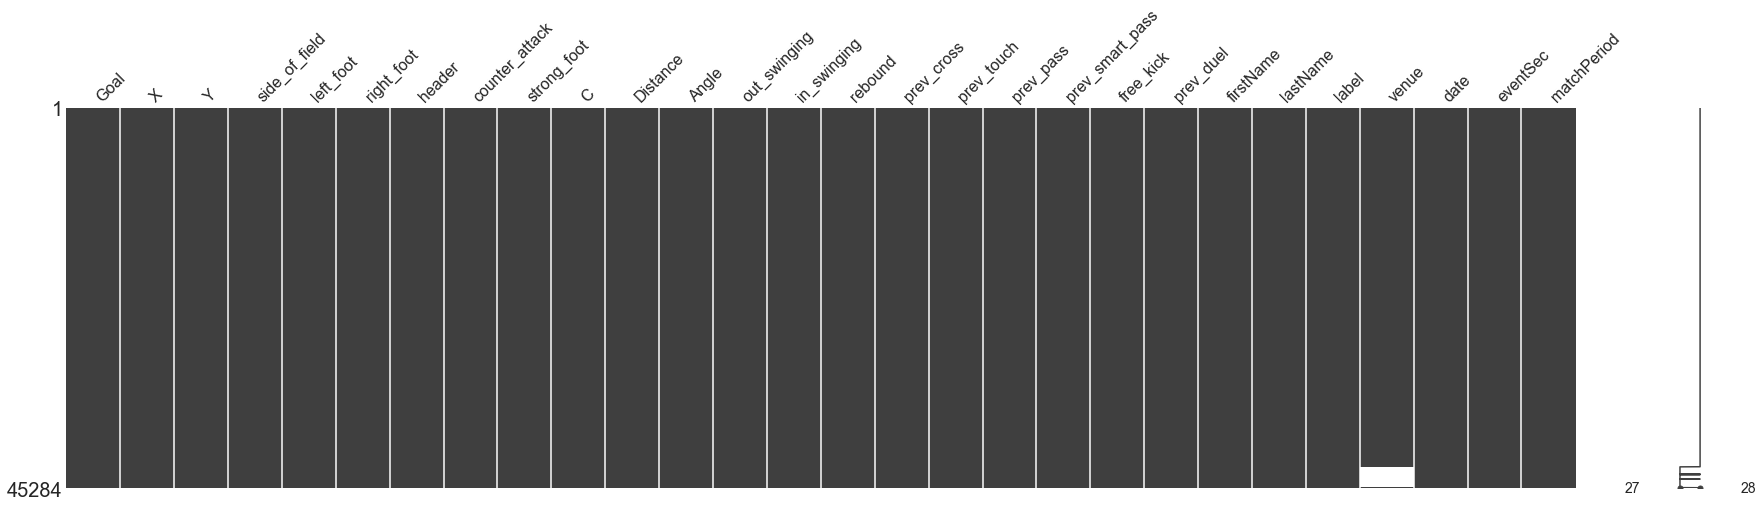

In [17]:
# Plot visualisation of the missing values for each feature of the raw DataFrame, shots_model
msno.matrix(shots_model, figsize = (30, 7))

In [18]:
# Counts of missing values
null_value_stats = shots_model.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

venue    2450
dtype: int64

The visualisation shows us very quickly that there a few missing values in the `value` column, but otherwise the dataset is complete.

---

## <a id='#section4'>4. Data Engineering</a>
Before we answer the questions in the brief through [Exploratory Data Analysis (EDA)](#section5), we'll first need to clean and wrangle the datasets to a form that meet our needs.

### <a id='#section4.1'>4.1. Filter Shots More than 75m Away</a>

In [19]:
shots_model = shots_model[shots_model['Distance'] < 75]

In [21]:
shots_model = shots_model.drop(columns=['firstName',  'lastName',  'label', 'venue', 'date', 'eventSec', 'matchPeriod'])

#### Visualise Shots in the Dataset

In [24]:
# Two dimensional histogram
H_Shot = np.histogram2d(shots_model['X'], shots_model['Y'], bins=50,range=[[0, 100], [0, 100]])
goals_only = shots_model[shots_model['Goal'] == 1]
H_Goal = np.histogram2d(goals_only['X'], goals_only['Y'], bins=50,range=[[0, 100], [0, 100]])

##### Number of goals

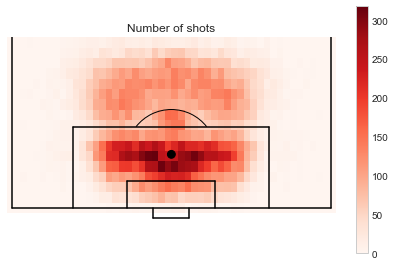

In [25]:
# Plot the number of shots from different points
(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(H_Shot[0], extent=[-1,66,104,-1], aspect='auto', cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax)
ax.set_title('Number of shots')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
#fig.savefig('Output/NumberOfShots.pdf', dpi=None, bbox_inches="tight")   

##### Number of shots

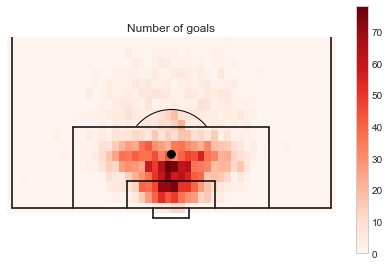

In [26]:
# Plot the number of GOALS from different points
(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(H_Goal[0], extent=[-1,66,104,-1], aspect='auto', cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax)
ax.set_title('Number of goals')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
#fig.savefig('Output/NumberOfGoals.pdf', dpi=None, bbox_inches="tight")  

##### Frequency of Scoring
Dividing the number of goals by the number of shots.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


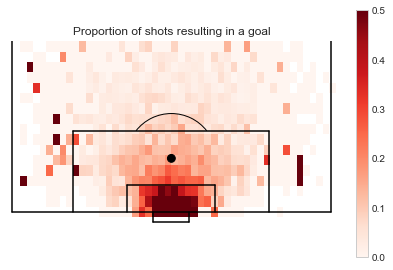

In [27]:
# Plot the probability of scoring from different points
(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(H_Goal[0]/H_Shot[0], extent=[-1,66,104,-1], aspect='auto', cmap=plt.cm.Reds, vmin=0, vmax=0.5)
fig.colorbar(pos, ax=ax)
ax.set_title('Proportion of shots resulting in a goal')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
#fig.savefig('Output/ProbabilityOfScoring.pdf', dpi=None, bbox_inches="tight")   

### <a id='#section4.2'>4.2. Normalise the location features</a>
In order to help the learning algorithm, we rescale the location features from their original scales to a normalized scale ranging from 0 to 1. More specifically, we divide the x coordinates by 105 and the y coordinates by 68.

In [ ]:
"""
shots_model['start_x_norm'] = shots_model['start_x'] / 105
shots_model['start_y_norm'] = shots_model['start_y'] / 68
shots_model['end_x_norm'] = shots_model['end_x'] / 105
shots_model['end_y_norm'] = shots_model['end_y'] / 68
"""

In [28]:
# Display DataFrame
shots_model

,Goal,X,Y,side_of_field,left_foot,right_foot,header,counter_attack,strong_foot,C,Distance,Angle,out_swinging,in_swinging,rebound,prev_cross,prev_touch,prev_pass,prev_smart_pass,free_kick,prev_duel
0,0,9,29,1,0,1,0,0,0,21.0,16.601958,0.257917,0,1,0,0,0,1,0,0,0
1,0,29,29,1,0,1,0,0,1,21.0,33.369522,0.199901,0,1,0,0,0,1,0,0,0
2,0,4,57,0,0,1,0,0,1,7.0,6.192132,0.889119,1,0,0,0,0,0,0,0,1
3,0,4,61,0,0,0,1,0,0,11.0,8.292316,0.506886,0,0,0,0,0,0,0,0,1
4,0,25,33,1,1,0,0,0,1,17.0,28.480959,0.236357,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45279,0,5,45,1,1,0,0,0,1,5.0,6.174545,0.999010,1,0,0,0,1,0,0,0,0
45280,0,7,38,1,1,0,0,0,1,12.0,10.717392,0.487547,1,0,0,0,0,0,1,0,0
45281,1,10,46,1,1,0,0,0,1,4.0,10.817116,0.638225,1,0,0,0,0,0,0,0,1
45282,0,21,32,1,0,1,0,0,1,18.0,24.961821,0.258795,0,1,0,0,0,1,0,0,0


---

## <a id='#section5'>5. Feature Engineering</a>
In order to predict the outcome of each shot, we need to transform our shots database into a dataset that we can fed into our machine learning algorithm. To this end, we perform the following three steps:

1. We compute the Eucledian distances between the start locations of each of the three actions and the center of the opposing goal. We add these three distances as features to our dataset as we expect them to help our machine learning algorithm to learn a more accurate model.

2. We construct our dataset by selecting a subset of the available features.

3. We split the dataset into a train set for training the model and a hold-out test set for evaluating the model. This is an important step as we aim to learn a predictive model that generalizes well to unseen examples. By evaluating our model on a hold-out test set, we can investigate whether we are overfitting on the train data.

### <a id='#section5.1'>5.1. Construct the dataset</a>
We construct our dataset by selecting a subset of the available features. In this how-to, we use a limited number of features such as the location of the shot (`action_start_x` and `action_start_y`), the body part used by the shot taker (`action_body_part_id`), and the distances between the locations of the three actions and the center of the opposing goal (`action_start_distance`, `action1_start_distance`, and `action2_start_distance`).

We encourage you to try other features as well and to investigate what effect they have on the performance of your expected-goals model. For example, you could try to include the angle between the shot location and the center of the goal or the angle between the shot location and the goal posts as a feature too. 

In [33]:
y = shots_model['Goal']
X = shots_model.drop(['Goal'], axis=1)

In [34]:
# DataFrame of Features
X.head()

,X,Y,side_of_field,left_foot,right_foot,header,counter_attack,strong_foot,C,Distance,Angle,out_swinging,in_swinging,rebound,prev_cross,prev_touch,prev_pass,prev_smart_pass,free_kick,prev_duel
0,9,29,1,0,1,0,0,0,21.0,16.601958,0.257917,0,1,0,0,0,1,0,0,0
1,29,29,1,0,1,0,0,1,21.0,33.369522,0.199901,0,1,0,0,0,1,0,0,0
2,4,57,0,0,1,0,0,1,7.0,6.192132,0.889119,1,0,0,0,0,0,0,0,1
3,4,61,0,0,0,1,0,0,11.0,8.292316,0.506886,0,0,0,0,0,0,0,0,1
4,25,33,1,1,0,0,0,1,17.0,28.480959,0.236357,1,0,0,0,0,1,0,0,0


In [35]:
# Series of Labels
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Goal, dtype: int64

### <a id='#section5.2'>5.2. Split the dataset into a train set and a test set</a>
We train our expected-goals model on 90% of the data and evaluate the model on the remaining 10% of the data.

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10)

---

## <a id='#section6'>6. Machine Learning Modelling</a>
We learn our expected-goals model using a Random Forest.

In [37]:
naive_rf_model = RandomForestClassifier(random_state=42)

In [39]:
naive_rf_model.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

We now need to evaluate the performance of our model. To do that, we will examine the log-loss and ROC-AUC score on both the training set and the testing set. For more information on these two metrics, please refer to @clekraus and David Sumpter's work on this matter, as they explain this in detail.

In [41]:
train_y_hat=naive_rf_model.predict_proba(X_train)
naive_train_log_loss=log_loss(y_train, train_y_hat[:,1])
naive_train_roc_auc=roc_auc_score(y_train, train_y_hat[:,1])
print('The log loss of our model on the training set is : ' +str(round(naive_train_log_loss, 4)))
print('The ROC AUC of our model on the training set is : ' +str(round(naive_train_roc_auc, 3)))

The log loss of our model on the training set is : 0.1463
The ROC AUC of our model on the training set is : 0.959


Note that for now, these metrics are pretty meaningless as there is nothing to compare them to. It is unclear what a log-loss of 0.1422 means, but will be useful when comparing two models to one another.

Let's take a look at these metrics on the test set, to see how our model performs on new data

In [43]:
test_y_hat=naive_rf_model.predict_proba(X_test)
naive_test_log_loss=log_loss(y_test, test_y_hat[:,1])
naive_test_roc_auc=roc_auc_score(y_test, test_y_hat[:,1])
print('The log loss of our model on the test set is : ' +str(round(naive_test_log_loss, 4)))
print('The ROC AUC of our model on the test set is : ' +str(round(naive_test_roc_auc, 3)))

The log loss of our model on the test set is : 1.4711
The ROC AUC of our model on the test set is : 0.688



Well, this is a problem! Our model performs really well on the training set, but terribly on our test set, which means that the model does not predict well on new data. Overfitting is a classic problem in machine learning, and we'll spend the rest of this notebook learning how to avoid this issue.

Another tool we have is a plot of the ROC/AUC curve. Fortunately, sklearn already has an implementation of that, so we'll just use that and compare the ROC/AUC between our models on the training set and the test set

In [44]:
train_fpr, train_tpr, train_thresholds = roc_curve(y_true=y_train, y_score=train_y_hat[:,1])
test_fpr, test_tpr, test_thresholds = roc_curve(y_true=y_test, y_score=test_y_hat[:,1])

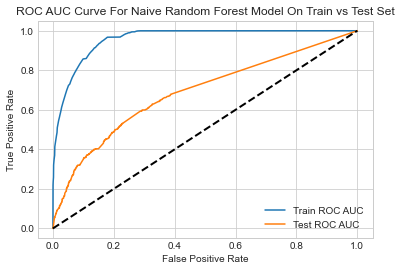

In [47]:
plt.plot(train_fpr, train_tpr, label='Train ROC AUC')
plt.plot(test_fpr, test_tpr, label='Test ROC AUC')
plt.plot([0, 1], [0, 1], color = 'black', linewidth = 2, linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC AUC Curve For Naive Random Forest Model On Train vs Test Set')
plt.show()

This hammers the point home further that this model performs very poorly on data it has not seen before. Thus, we need to dive deeper into what is going on.

### <a id='#section5.1'>5.1. Compute additional features</a>
We compute the Eucledian distances between the start location of each of the three actions and the center of the opposing goal, which is located at coordinates (1, 0.5) in our normalised coordinate representation.

In [ ]:
# Normalised location for the center of the opposing goal
goal = (1, 0.5)

In [ ]:
# Define the three key actions
shots_model['start_distance'] = shots_model.apply(lambda s: distance.euclidean((s['start_x_norm'], s['start_y_norm']), goal), axis=1)

### <a id='#section5.2'>5.2. Construct the dataset</a>
We construct our dataset by selecting a subset of the available features. In this how-to, we use a limited number of features such as the location of the shot (`action_start_x` and `action_start_y`), the body part used by the shot taker (`action_body_part_id`), and the distances between the locations of the three actions and the center of the opposing goal (`action_start_distance`, `action1_start_distance`, and `action2_start_distance`).

We encourage you to try other features as well and to investigate what effect they have on the performance of your expected-goals model. For example, you could try to include the angle between the shot location and the center of the goal or the angle between the shot location and the goal posts as a feature too. 

In [ ]:
shots_model

In [ ]:
# Features
columns_features = ['start_x_norm', 'start_y_norm', 'bodypart_id', 'start_distance']

# Label: 1 if a goal, 0 otherwise
column_target = 'result_id'

In [ ]:
X = shots_model[columns_features]
y = shots_model[column_target]

### <a id='#section5.3'>5.3. Split the dataset into a train set and a test set</a>
We train our expected-goals model on 90% of the data and evaluate the model on the remaining 10% of the data.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10)

---

## <a id='#section6'>6. Machine Learning Modelling</a>
We learn our expected-goals model using the XGBoost algorithm, which is a popular algorithm in machine learning competitions like Kaggle. The algorithm is particularly appealing as it requires minimal parameter tuning to provide decent performance on many standard machine learning tasks.

For more information about XGBoost, see the official docs [[link](http://xgboost.readthedocs.io/en/latest/model.html)].

### <a id='#section6.1'>6.1. Option 1: Train an XGBoost classifier using manually set hyperparameters</a>
We train an XGBoost classifier on our train set. We train 100 trees and set their maximum depth to 5.

In [ ]:
classifier = XGBClassifier(objective='binary:logistic', max_depth=5, n_estimators=100)
classifier.fit(X_train, y_train)

### <a id='#section6.2'>6.2. Option 2: Train an XGBoost classifier using grid search to automatically optimize the hyperparameters</a>
We train an XGBoost classifier on our train set by performing a grid search over a set of reasonable hyperparameters to find the optimal hyperparameters for this task. We vary the maximum depths of the trees from 3 to 6 and try learning 100, 500, and 1000 trees. We use the default three-fold cross-validation approach to find the best set of hyperparameters.

We encourage you to explore different values for the hyperparameters as well. The following page offers an overview of the hyperparameters that can be tuned: [XGBoost Parameters](http://xgboost.readthedocs.io/en/latest/parameter.html). 

In [ ]:
parameters = {
    'nthread': [4],
    'objective': ['binary:logistic'],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01],
    'n_estimators': [100, 500, 1000],
    'seed': [42]
}

classifier = XGBClassifier()
classifier = GridSearchCV(classifier, parameters, scoring='roc_auc', verbose=2)
classifier.fit(X_train, y_train)

In [ ]:
# Print out the XGBoost model metrics
print("---XGBoost Metrics---")
print("Accuracy: {}".format(acc_catboost))
print("Accuracy cross-validation 10-Fold: {}".format(acc_cv_catboost))
print("Running Time: {}".format(datetime.timedelta(seconds=catboost_time)))

### <a id='#section6.3'>6.3. Option 3: Train an CatBoost classifier</a>
[CatBoost](https://catboost.ai/) is a state-of-the-art, open-source gradient boosting on-decision trees library created by [Yandex](https://yandex.com/).

It's simple and easy to use. And is now regularly one of my go-to algorithms for any kind of machine learning task.

For more on CatBoost and the methods it uses to deal with categorical variables, check out the [CatBoost docs](https://catboost.ai/).

The [CatBoost Python tutorial on GitHub](https://github.com/catboost/tutorials/blob/master/python_tutorial.ipynb) uses the the Titanic Dataset and has some great tricks to improve the results in this notebook. [Anna Veronika Dorogush](https://www.linkedin.com/in/anna-veronika-dorogush-08739637/) has also presented [Mastering gradient boosting with CatBoost](https://www.youtube.com/watch?v=usdEWSDisS0) lecture at [PyData 2019 London](https://pydata.org/london2019/) explaining more about CatBoost and how it works.

In [ ]:
X_train

In [ ]:
# Define the categorical features for the CatBoost model
cat_features = np.where(X_train.dtypes != np.float)[0]
cat_features

This means Catboost has picked up that all variables except `Fare` can be treated as categorical.

In [ ]:
# Use the CatBoost Pool() function to pool together the training data and categorical feature labels
train_pool = Pool(X_train, 
                  y_train,
                  cat_features)

In [ ]:
y_train.head()

In [ ]:
# CatBoost model definition
catboost_model = CatBoostClassifier(iterations=1000,
                                    custom_loss=['Accuracy'],
                                    loss_function='Logloss')

# Fit CatBoost model
catboost_model.fit(train_pool,
                   plot=True)

# CatBoost accuracy
acc_catboost = round(catboost_model.score(X_train, y_train) * 100, 2)

##### Perform CatBoost cross-validation

In [ ]:
# How long will this take?
start_time = time.time()

# Set params for cross-validation as same as initial model
cv_params = catboost_model.get_params()

# Run the cross-validation for 10-folds (same as the other models)
cv_data = cv(train_pool,
             cv_params,
             fold_count=10,
             plot=True)

# How long did it take?
catboost_time = (time.time() - start_time)

# CatBoost CV results save into a dataframe (cv_data), let's withdraw the maximum accuracy score
acc_cv_catboost = round(np.max(cv_data['test-Accuracy-mean']) * 100, 2)

In [ ]:
# Print out the CatBoost model metrics
print("---CatBoost Metrics---")
print("Accuracy: {}".format(acc_catboost))
print("Accuracy cross-validation 10-Fold: {}".format(acc_cv_catboost))
print("Running Time: {}".format(datetime.timedelta(seconds=catboost_time)))

---

## <a id='#section7'>7. Model Evaluation</a>
We evaluate the accuracy of our xG model by making predictions for the shots in our test set.

### <a id='#section7.1'>7.1. Predict the test examples</a>

In [ ]:
# For each shot, predict the probability of the shot resulting in a goal
y_pred = classifier.predict_proba(X_test)

### <a id='#section7.2'>7.2. Compute area under the curve: receiver operating characteristic (AUC-ROC)</a>
To measure the accuracy of our expected-goals model, we compute the AUC-ROC obtained on the test set. The values for the AUC-ROC metric range from 0 to 1. The higher the AUC-ROC value is, the better the classifier is, where an AUC-ROC value of 0.50 corresponds to random guessing. That is, if we randomly predicted whether a shot results in a goal or not, we would obtain an AUC-ROC of 0.50.

In [ ]:
y_total = y_train.count()
y_positive = y_train.sum()

print('The training set contains {} examples of which {} are positives.'.format(y_total, y_positive))

In [ ]:
auc_roc = roc_auc_score(y_test, y_pred[:, 1])

print('Our classifier obtains an AUC-ROC of {}.'.format(auc_roc))

### <a id='#section7.3'>7.3. Compute area under the curve: precision-recall (AUC-PR)</a>
Since the AUC-ROC metric is susceptible to class imbalance (i.e., the number of positive examples is much lower or higher than the number of negative examples), we also compute the AUC-PR obtained on the test set. The values for the AUC-PR metric range from 0 to 1 too. The higher the AUC-PR value is, the better the classifier is. Unlike AUC-ROC, however, the value for random guessing does not necessarily correspond to 0.50 for imbalanced classes, but corresponds to the ratio of positive examples in the train set.

In [ ]:
auc_pr_baseline = y_positive / y_total

print('The baseline performance for AUC-PR is {}.'.format(auc_pr_baseline))

In [ ]:
auc_pr = average_precision_score(y_test, y_pred[:, 1])

print('Our classifier obtains an AUC-PR of {}.'.format(auc_pr))

### <a id='#section7.4'>7.4. Plot AUC-ROC curve</a>

In [ ]:
plot_roc_curve(y_test, y_pred, curves='each_class')

### <a id='#section7.5'>7.5. Plot AUC-PR curve</a>

In [ ]:
plot_precision_recall_curve(y_test, y_pred, curves='each_class')

### <a id='#section7.6'>7.6. Plot Calibration curve</a>
We plot a calibration curve to investigate how well our expected-goals model is calibrated. The plot shows the mean predicted value on the horizontal axis and the fraction of covered positive examples on the vertical axis.

In [ ]:
plot_calibration_curve(y_test, [y_pred])

---

## <a id='#section8'>8. Summary</a>
This notebook is a short walkthrough of the process for building a simple Expected Goals model that produces an Expected Goals value for each shot that happened during a game of football. Our how-to is available as a Jupyter notebook and showcases some of the tools and technologies our data analytics team uses to build their analytics models and metrics.

---

## <a id='#section9'>9. Next Steps</a>
The step is to ...

---

## <a id='#section11'>10. References</a>
*    [Tom Decroos](https://twitter.com/TomDecroos), [Lotte Bransen](https://twitter.com/LotteBransen), [Jan Van Haaren](https://twitter.com/JanVanHaaren), and [Jesse Davis](https://twitter.com/jessejdavis1). [Actions Speak Louder than Goals: Valuing Player Actions in Soccer](https://arxiv.org/abs/1802.07127). In *Proceedings of the 25th ACM SIGKDD International Conference on Knowledge Discovery & Data Mining*, pp. 1851-1861. 2019.
*    Luca Pappalardo, Paolo Cintia, Alessio Rossi, Emanuele Massucco, Paolo Ferragina, Dino Pedreschi, and Fosca Giannotti. "[A Public Data Set of Spatio-Temporal Match Events in Soccer Competitions](https://www.nature.com/articles/s41597-019-0247-7)" *Scientific Data 6*, no. 1 (2019): 1-15.(https://www.nature.com/articles/s41597-019-0247-7). Scientific Data 6, no. 1 (2019): 1-15.
*    [Tech how-to: build your own Expected Goals model by SciSports](https://www.scisports.com/tech-how-to-build-your-own-expected-goals-model/)

---

## <a id='#section11'>11. Further Reading</a>
*    [The Future of Stats: xG, xA by Tifo Football Podcast](https://www.youtube.com/watch?v=sNCeA27sDvI)
*    [What is xG? YouTube video by Tifo Football](https://www.youtube.com/watch?v=zSaeaFcm1SY)
*    What are Expected Assists? YouTube video by Tifo Football](https://www.youtube.com/watch?v=1MdlkuzLdj4)
<br>

---

***Visit my website [EddWebster.com](https://www.eddwebster.com) or my [GitHub Repository](https://github.com/eddwebster) for more projects. If you'd like to get in contact, my Twitter handle is [@eddwebster](http://www.twitter.com/eddwebster) and my email is: edd.j.webster@gmail.com.***

[Back to the top](#top)